In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr

In [16]:
g4_tool = 'regex'

SPECIES_DATA = "../results/species_data.csv"
G4_DIST = f"../results/{g4_tool}_g4_distribution.csv"
GFF_DATA = "../results/gff_feature_data.csv"

def get_domain(taxa):
    if taxa == 'viral':
        return 'Virus'
    elif taxa == 'bacteria':
        return 'Bacteria'
    elif taxa == 'archaea':
        return 'Archaea'
    else:
        return 'Eukaryota'    

# set color map for domains
color_map = {
    'Virus': '#66c2a5',
    'Bacteria': '#fc8d62',
    'Eukaryota': '#8da0cb',
    'Archaea': '#e78ac3'
}

In [17]:
# species data
df_species = pd.read_csv(SPECIES_DATA)
df_species = df_species[["Accession", "Genome Size", "Taxa"]]
df_species = df_species.replace('na', np.nan)
df_species["Domain"] = df_species["Taxa"].apply(get_domain)
df_species.set_index('Accession', inplace=True)

# g4 distribution data
df_dist = pd.read_csv(G4_DIST)
df_dist.set_index('accession', inplace=True)
df_dist = df_dist[['total_g4_length', 'g4_count']]
df_dist.columns = ['Total G4 Length', 'G4 Count']
df_dist = df_dist.astype(float)

# gff data
df_gff = pd.read_csv(GFF_DATA)
df_gff.set_index('accession', inplace=True)
df_gff = df_gff[['gene', 'exon', 'CDS']]
df_gff.columns = ['Genes', 'Exons', 'CDS']
df_gff = df_gff.astype(float)

# merge dataframes
df_g4 = df_species.join(df_dist, how='inner')
df_g4 = df_g4.join(df_gff, how='inner')
df_g4.reset_index(inplace=True)
df_g4.rename(columns={'index': 'Accession'}, inplace=True)
df_g4.head()

,Accession,Genome Size,Taxa,Domain,Total G4 Length,G4 Count,Genes,Exons,CDS
0,GCA_000002515.1,10689156,fungi,Eukaryota,890.0,36.0,7509678.0,35663.0,7394184.0
1,GCA_000002765.3,23292622,protozoa,Eukaryota,20268.0,837.0,13658969.0,118336.0,12451712.0
2,GCA_000006645.1,4701745,bacteria,Bacteria,1652.0,66.0,3916203.0,39060.0,3878552.0
3,GCA_000006605.1,2476822,bacteria,Bacteria,4017.0,154.0,2232019.0,18704.0,2209637.0
4,GCA_000006685.1,1080451,bacteria,Bacteria,87.0,3.0,988387.0,12072.0,967121.0


In [18]:
# filter out metagenomes and other taxa as they are not relevant for domain level analysis
df_g4 = df_g4[df_g4["Taxa"] != "metagenomes"]
df_g4 = df_g4[df_g4["Taxa"] != "other"]

df_g4 = df_g4.dropna(subset=["Genes"])
df_g4['Gene Density'] = df_g4['Genes'] / df_g4["Genome Size"] * 1000000
df_g4['Exon Density'] = df_g4['Exons'] / df_g4["Genome Size"] * 1000000
df_g4['CDS Density'] = df_g4['CDS'] / df_g4["Genome Size"] * 1000000
df_g4['G4 Density'] = df_g4['G4 Count'] / df_g4["Genome Size"] * 1000000
df_g4.head()

,Accession,Genome Size,Taxa,Domain,Total G4 Length,G4 Count,Genes,Exons,CDS,Gene Density,Exon Density,CDS Density,G4 Density
0,GCA_000002515.1,10689156,fungi,Eukaryota,890.0,36.0,7509678.0,35663.0,7394184.0,702551.071385,3336.371927,691746.289417,3.367899
1,GCA_000002765.3,23292622,protozoa,Eukaryota,20268.0,837.0,13658969.0,118336.0,12451712.0,586407.532823,5080.407006,534577.515576,35.934125
2,GCA_000006645.1,4701745,bacteria,Bacteria,1652.0,66.0,3916203.0,39060.0,3878552.0,832925.435131,8307.553898,824917.557205,14.037341
3,GCA_000006605.1,2476822,bacteria,Bacteria,4017.0,154.0,2232019.0,18704.0,2209637.0,901162.457375,7551.612510,892125.877435,62.176450
4,GCA_000006685.1,1080451,bacteria,Bacteria,87.0,3.0,988387.0,12072.0,967121.0,914791.138145,11173.111969,895108.616680,2.776618


Text(0.1, 0.9, "Spearman's R: 0.00\np-value: 0.56")

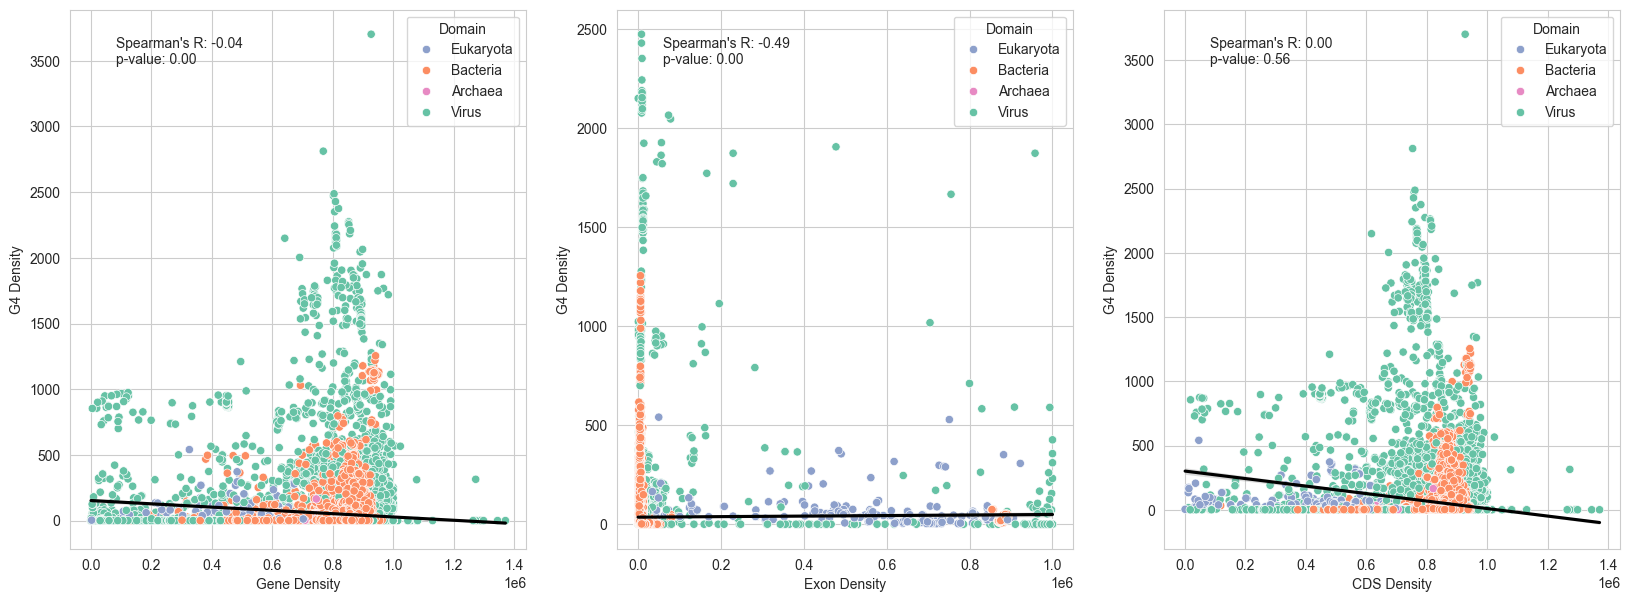

In [19]:
# scatter plot with subplots
fig, ax = plt.subplots(1, 3, figsize=(20, 7))

# create new dataframe for exon and cds density with nan values removed
df_g4_exon = df_g4.dropna(subset=['Exon Density'])
df_g4_cds = df_g4.dropna(subset=['CDS Density'])

# plot gene density vs g4 density
sns.scatterplot(
    data=df_g4, 
    x='Gene Density', 
    y='G4 Density', 
    hue='Domain', 
    palette=color_map, 
    ax=ax[0]
)
sns.regplot(
	data=df_g4, 
	x='Gene Density', 
	y='G4 Density', 
	scatter=False, 
	color='black', 
	ax=ax[0]
)
# plot exon density vs g4 density
sns.scatterplot(
	data=df_g4_exon, 
	x='Exon Density', 
	y='G4 Density', 
	hue='Domain', 
	palette=color_map, 
	ax=ax[1]
)
sns.regplot(
	data=df_g4_exon, 
	x='Exon Density', 
	y='G4 Density', 
	scatter=False, 
	color='black', 
	ax=ax[1]
)
# plot cds density vs g4 density
sns.scatterplot(
	data=df_g4_cds, 
	x='CDS Density', 
	y='G4 Density', 
	hue='Domain', 
	palette=color_map, 
	ax=ax[2]
)
sns.regplot(
	data=df_g4_cds, 
	x='CDS Density', 
	y='G4 Density', 
	scatter=False, 
	color='black', 
	ax=ax[2]
)

# display spearman correlation coefficient
gene_corr, gene_p = spearmanr(df_g4['Gene Density'], df_g4['G4 Density'])
exon_corr, exon_p = spearmanr(df_g4_exon['Exon Density'], df_g4_exon['G4 Density'])
cds_corr, cds_p = spearmanr(df_g4_cds['CDS Density'], df_g4_cds['G4 Density'])
ax[0].text(0.1, 0.9, f"Spearman's R: {gene_corr:.2f}\np-value: {gene_p:.2f}", transform=ax[0].transAxes)
ax[1].text(0.1, 0.9, f"Spearman's R: {exon_corr:.2f}\np-value: {exon_p:.2f}", transform=ax[1].transAxes)
ax[2].text(0.1, 0.9, f"Spearman's R: {cds_corr:.2f}\np-value: {cds_p:.2f}", transform=ax[2].transAxes)

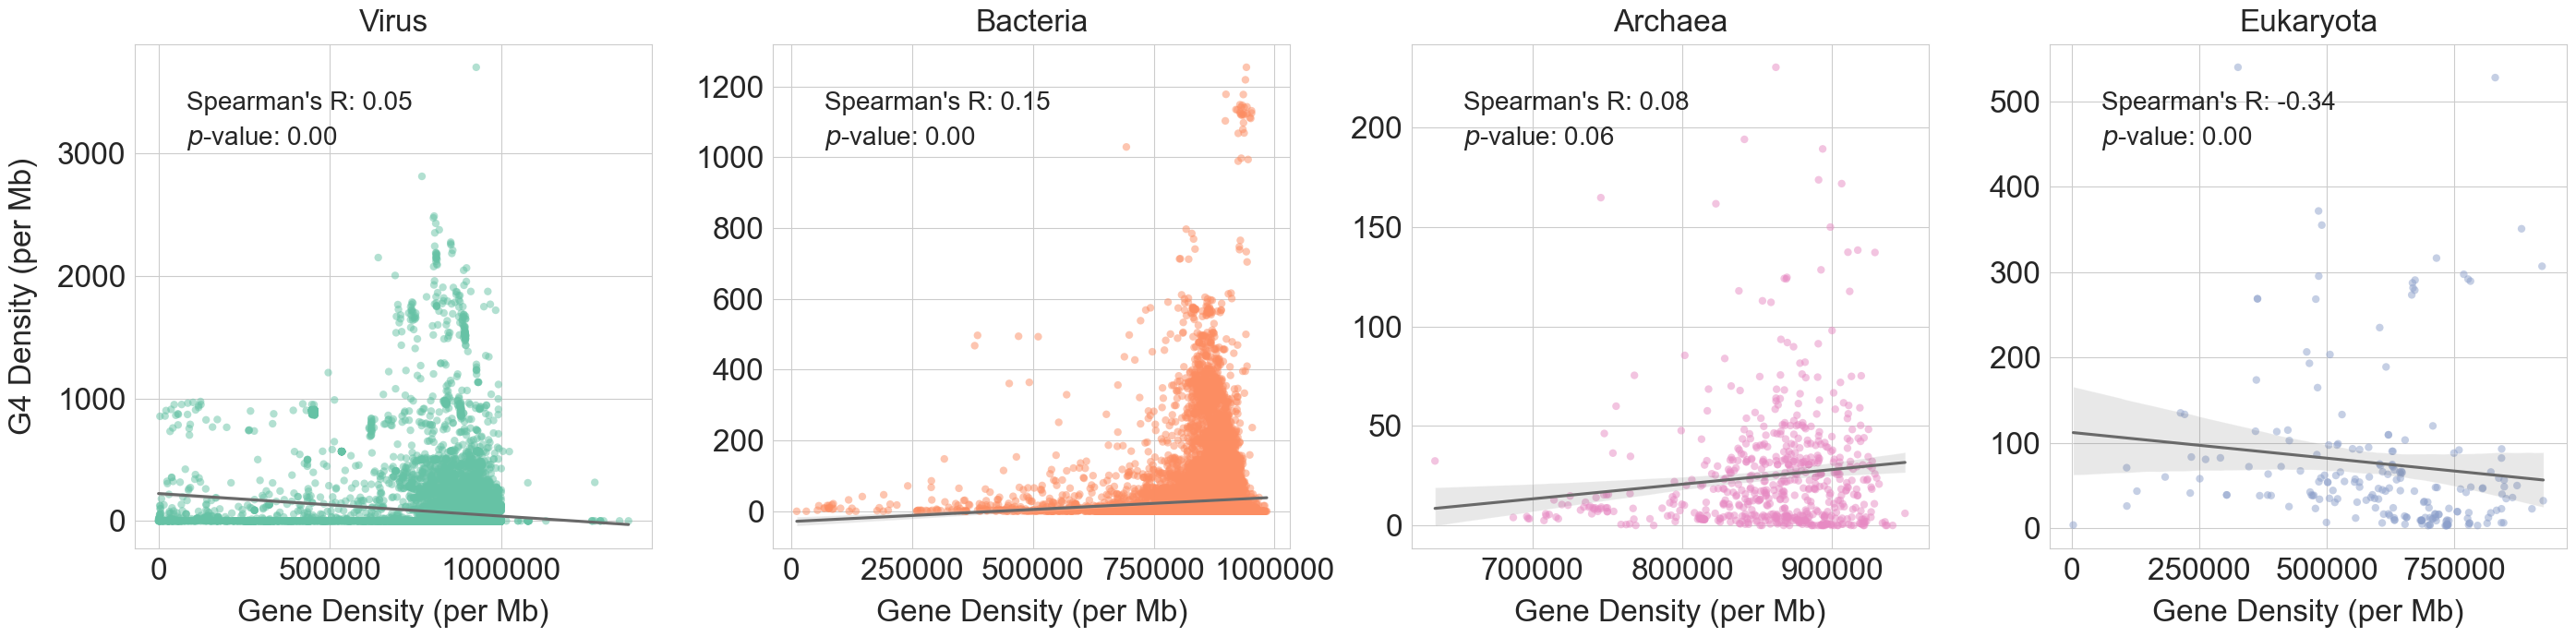

In [20]:
# plot g4 density vs gene density for each domain
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 4, figsize=(28, 7))

domains = ['Virus', 'Bacteria', 'Archaea', 'Eukaryota']
for i, domain in enumerate(domains):
	domain_data = df_g4[df_g4['Domain'] == domain]
	sns.scatterplot(
		data=domain_data,
		x='Gene Density',
		y='G4 Density',
		alpha=0.5,
		edgecolor='none',
		ax=ax[i],
		color=color_map[domain]
	)
	sns.regplot(
		data=domain_data,
		x='Gene Density',
		y='G4 Density',
		ax=ax[i],
		scatter=False,
		color='dimgrey'
	)
	ax[i].set_title(domain, fontsize=24, pad=10)
	ax[i].set_xlabel('Gene Density (per Mb)', fontsize=24, labelpad=10)
	if i == 0:
		ax[i].set_ylabel('G4 Density (per Mb)', fontsize=24, labelpad=15)

	else:
		ax[i].set_ylabel('')
	ax[i].tick_params(axis='both', which='major', labelsize=24)
	# don't use scientific notation for x axis
	ax[i].ticklabel_format(style='plain', axis='x')

	# display spearman correlation coefficient
	corr, p = spearmanr(domain_data['Gene Density'], domain_data['G4 Density'])
	ax[i].text(0.1, 0.87, f"Spearman's R: {corr:.2f}", transform=ax[i].transAxes, fontsize=20)
	ax[i].text(0.1, 0.80, rf"$\it{{p}}$-value: {p:.2f}", transform=ax[i].transAxes, fontsize=20)

plt.tight_layout()
plt.savefig(f"../plots/gene_density_g4_density_domain_{g4_tool}.png")

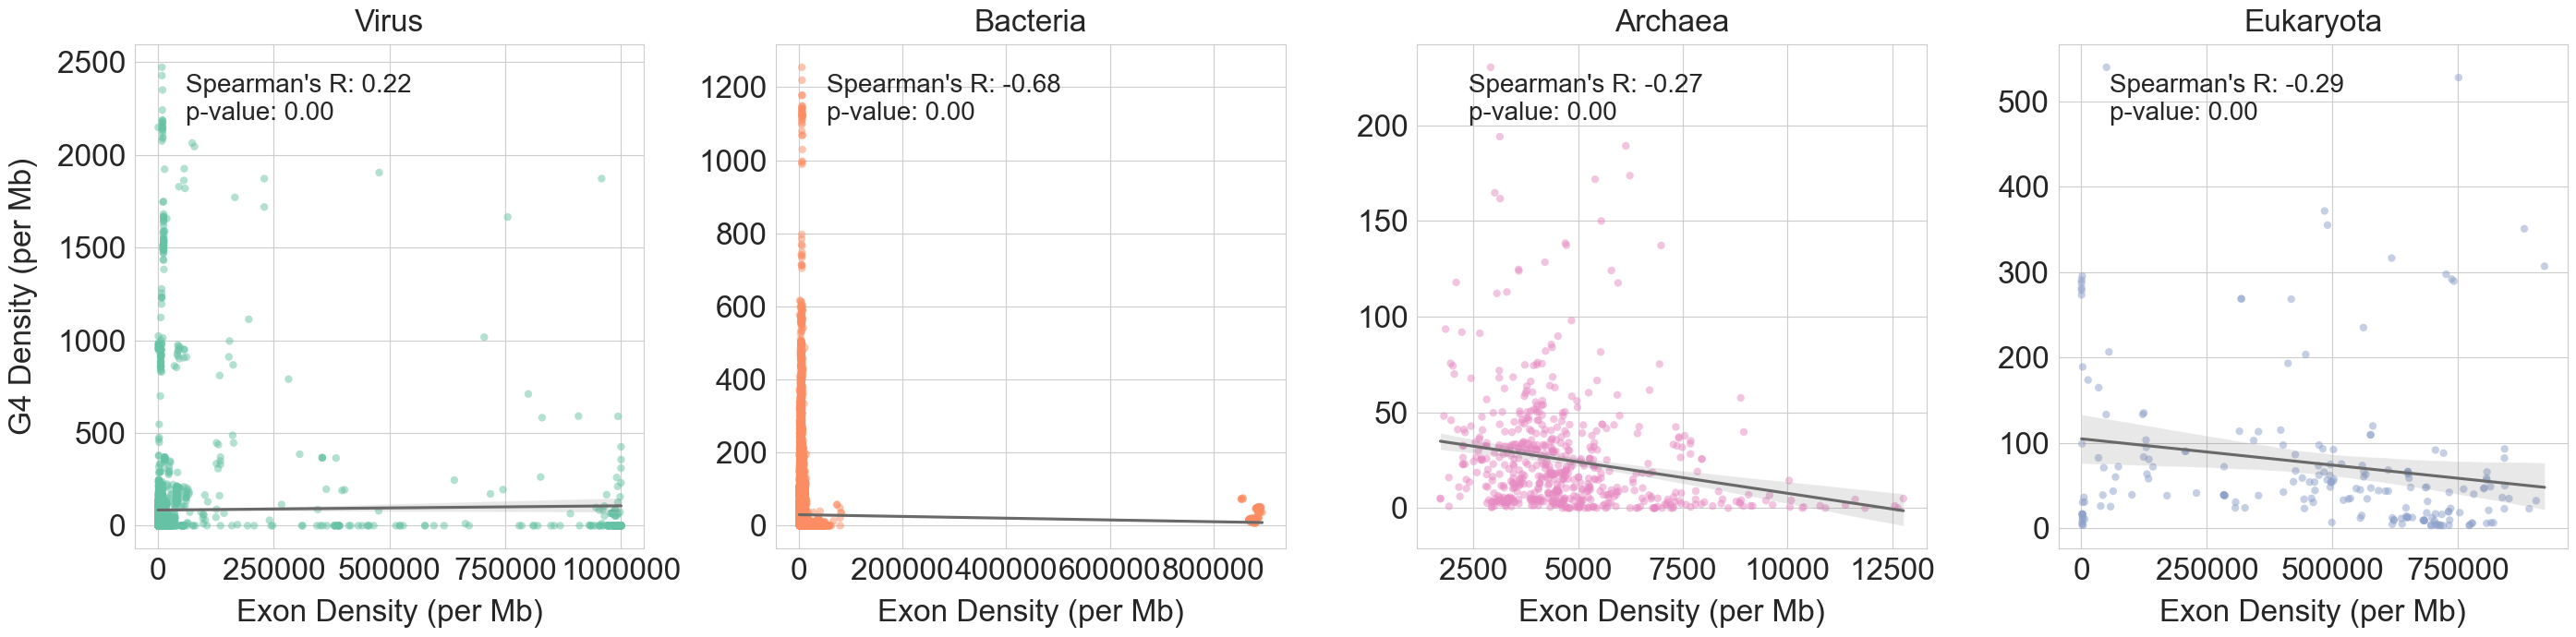

In [21]:
# plot g4 density vs exon density for each domain
fig, ax = plt.subplots(1, 4, figsize=(28, 7))
domains = ['Virus', 'Bacteria', 'Archaea', 'Eukaryota']
for i, domain in enumerate(domains):
	domain_data = df_g4_exon[df_g4_exon['Domain'] == domain]
	sns.scatterplot(
		data=domain_data,
		x='Exon Density',
		y='G4 Density',
		alpha=0.5,
		edgecolor='none',
		ax=ax[i],
		color=color_map[domain]
	)
	sns.regplot(
		data=domain_data,
		x="Exon Density",
		y="G4 Density",
		ax=ax[i],
		scatter=False,
		color='dimgrey'
	)
	# formatting
	ax[i].set_title(domain, fontsize=24, pad=10)
	ax[i].set_xlabel('Exon Density (per Mb)', fontsize=24, labelpad=10)
	if i == 0:
		ax[i].set_ylabel('G4 Density (per Mb)', fontsize=24, labelpad=15)
	else:
		ax[i].set_ylabel('')
	ax[i].tick_params(axis='both', which='major', labelsize=24)
	# don't use scientific notation for x axis
	ax[i].ticklabel_format(style='plain', axis='x')

	# display spearman correlation coefficient
	corr, p = spearmanr(domain_data['Exon Density'], domain_data['G4 Density'])
	ax[i].text(0.1, 0.85, f"Spearman's R: {corr:.2f}\np-value: {p:.2f}", transform=ax[i].transAxes, fontsize=20)

plt.tight_layout()

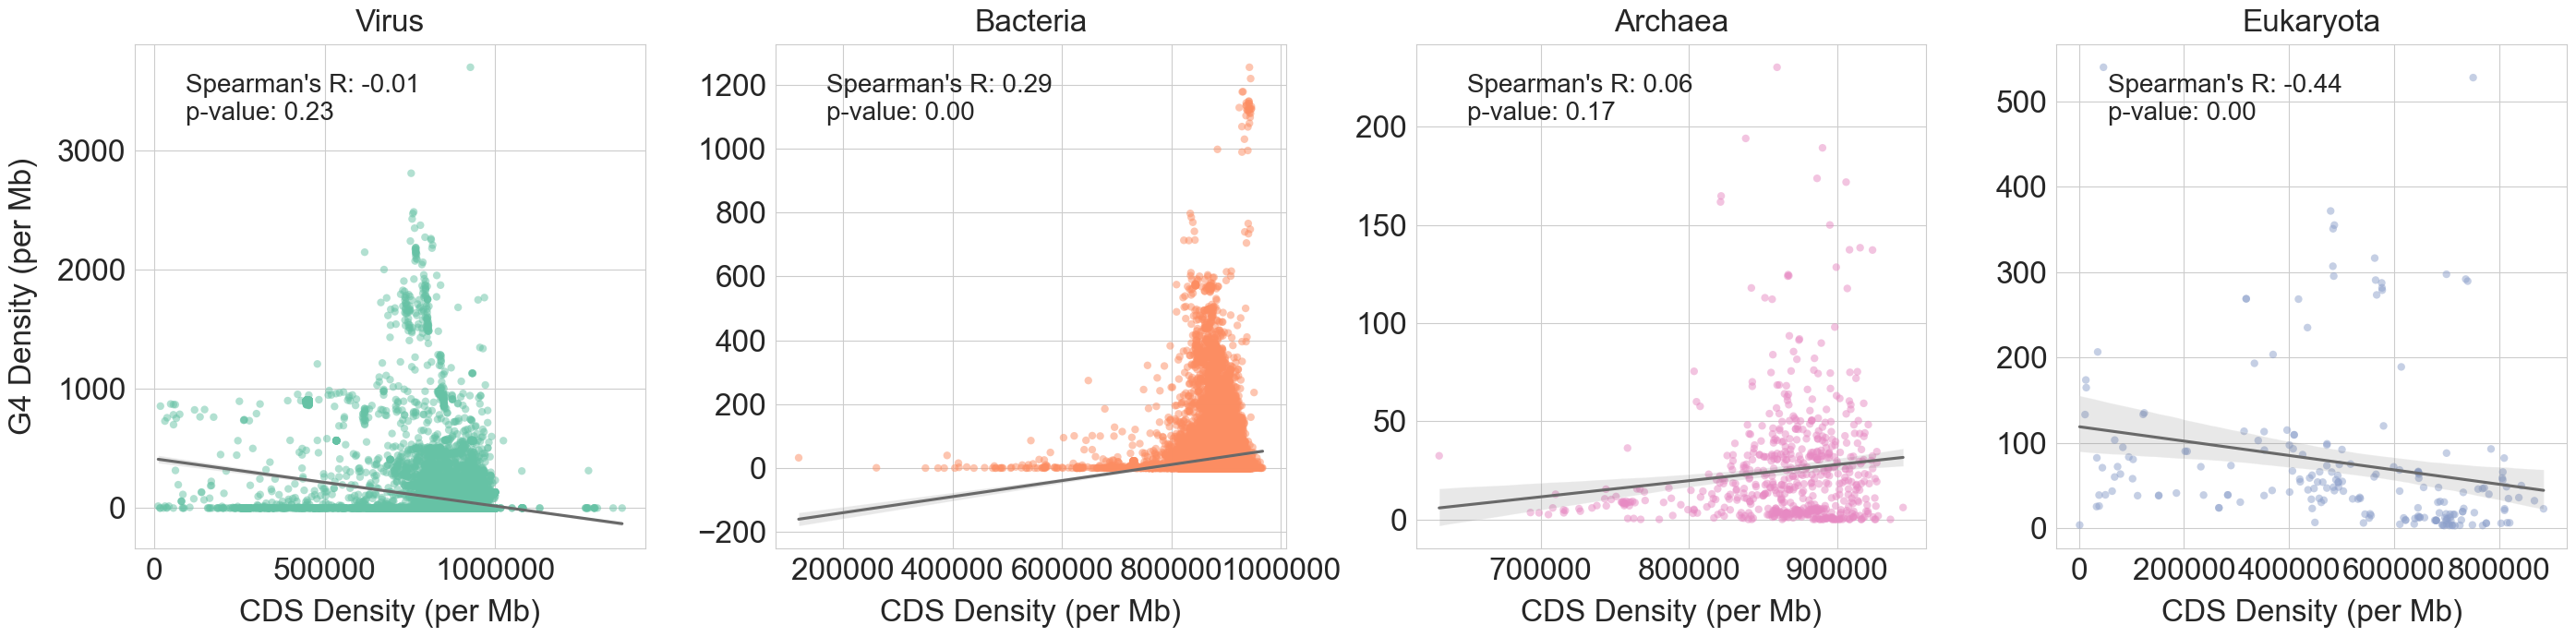

In [22]:
# plot g4 density vs cds density for each domain
fig, ax = plt.subplots(1, 4, figsize=(28, 7))
domains = ['Virus', 'Bacteria', 'Archaea', 'Eukaryota']
for i, domain in enumerate(domains):
	domain_data = df_g4_cds[df_g4_cds['Domain'] == domain]
	sns.scatterplot(
		data=domain_data,
		x='CDS Density',
		y='G4 Density',
		alpha=0.5,
		edgecolor='none',
		ax=ax[i],
		color=color_map[domain]
	)
	sns.regplot(
		data=domain_data,
		x="CDS Density",
		y="G4 Density",
		ax=ax[i],
		scatter=False,
		color='dimgrey'
	)
	# formatting
	ax[i].set_title(domain, fontsize=24, pad=10)
	ax[i].set_xlabel('CDS Density (per Mb)', fontsize=24, labelpad=10)
	if i == 0:
		ax[i].set_ylabel('G4 Density (per Mb)', fontsize=24, labelpad=15)
	else:
		ax[i].set_ylabel('')
	ax[i].tick_params(axis='both', which='major', labelsize=24)
	# don't use scientific notation for x axis
	ax[i].ticklabel_format(style='plain', axis='x')
	# display spearman correlation coefficient
	corr, p = spearmanr(domain_data['CDS Density'], domain_data['G4 Density'])
	ax[i].text(0.1, 0.85, f"Spearman's R: {corr:.2f}\np-value: {p:.2f}", transform=ax[i].transAxes, fontsize=20)

plt.tight_layout()